In [2]:
import os
import sys
import json
import argparse

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

from glob import glob
from nilearn import plotting

In [3]:

# ### import data with `pybids` 
# based on: https://github.com/bids-standard/pybids/blob/master/examples/pybids_tutorial.ipynb
def import_bids_data(bidsroot, subject_id, task_label):
    from bids import BIDSLayout

    layout = BIDSLayout(bidsroot)

    all_files = layout.get()
    t1w_fpath = layout.get(return_type='filename', subject=subject_id, 
                            suffix='T1w', extension='nii.gz')[0]
    bold_files = layout.get(return_type='filename', subject=subject_id, 
                            suffix='bold', task=task_label, extension='nii.gz')
    return all_files, t1w_fpath, bold_files



In [4]:

# ## nilearn modeling: first level
# based on: https://nilearn.github.io/auto_examples/04_glm_first_level/plot_bids_features.html#sphx-glr-auto-examples-04-glm-first-level-plot-bids-features-py

def prep_models_and_args(subject_id=None, task_id=None, fwhm=None, bidsroot=None, 
                         deriv_dir=None, event_type=None, t_r=None, t_acq=None, space_label='T1w'):
    from nilearn.glm.first_level import first_level_from_bids
    from nilearn.interfaces.fmriprep import load_confounds

    data_dir = bidsroot

    task_label = task_id
    fwhm_sub = fwhm

    # correct the fmriprep-given slice reference (middle slice, or 0.5)
    # to account for sparse acquisition (silent gap during auditory presentation paradigm)
    # fmriprep is explicitly based on slice timings, while nilearn is based on t_r
    # and since images are only collected during a portion of the overall t_r (which includes the silent gap),
    # we need to account for this
    slice_time_ref = 0.5 * t_acq / t_r

    print(data_dir, task_label, space_label)

    models, models_run_imgs, models_events, models_confounds = first_level_from_bids(data_dir, task_label, space_label,
                                                                                     [subject_id],
                                                                                     smoothing_fwhm=fwhm,
                                                                                     derivatives_folder=deriv_dir,
                                                                                     slice_time_ref=slice_time_ref,
                                                                                     minimize_memory=False)

    # fill n/a with 0
    [[mc.fillna(0, inplace=True) for mc in sublist] for sublist in models_confounds]

    # define which confounds to keep as nuisance regressors
    conf_keep_list = ['framewise_displacement',
    #                #'a_comp_cor_00', 'a_comp_cor_01', 
    #                #'a_comp_cor_02', 'a_comp_cor_03', 
    #                #'a_comp_cor_04', 'a_comp_cor_05', 
    #                #'a_comp_cor_06', 'a_comp_cor_07', 
    #                #'a_comp_cor_08', 'a_comp_cor_09', 
                    'trans_x', 'trans_y', 'trans_z', 
                    'rot_x','rot_y', 'rot_z']

    ''' create events '''
    '''
    for sx, sub_events in enumerate(models_events):
        print(models[sx].subject_label)
        for mx, run_events in enumerate(sub_events):
            # block design
            if event_type == 'block_stim':
                run_events = run_events.groupby('trial_type', sort=False, as_index=False).first()
                run_events.drop(run_events[run_events.trial_type=='null'].index, inplace=True)
                run_events.duration = 20
        
            if event_type == 'block_sound':
                run_events = run_events.groupby('trial_type', sort=False, as_index=False).first()
                run_events.drop(run_events[run_events.trial_type=='null'].index, inplace=True)
                run_events.duration = 20
                run_events.trial_type = 'sound'
    
            # stimulus events
            if event_type == 'stimulus':
                name_groups = run_events.groupby('trial_type')['trial_type']
                suffix = name_groups.cumcount() + 1
                repeats = name_groups.transform('size')

                run_events['trial_type'] = run_events['trial_type']
                run_events['trial_type'] = run_events['trial_type'].str.replace('-','_')

            # trial-specific events          
            if event_type == 'trial':
                name_groups = run_events.groupby('trial_type')['trial_type']
                suffix = name_groups.cumcount() + 1
                repeats = name_groups.transform('size')

                run_events['trial_type'] = run_events['trial_type'] + \
                                                    '_trial' + suffix.map(str)
                run_events['trial_type'] = run_events['trial_type'].str.replace('-','_')

            # all sound events
            elif event_type == 'sound':
                orig_stim_list = sorted([str(s) for s in run_events['trial_type'].unique() 
                                         if str(s) not in ['nan', 'None', 'null']])
                #print('original stim list: ', orig_stim_list)

                run_events['trial_type'] = run_events.trial_type.str.split('_', expand=True)[0]

            # re-assign to models_events
            models_events[sx][mx] = run_events
        '''
        # create stimulus list from updated events.tsv file
        #stim_list = sorted([str(s) for s in run_events['trial_type'].unique() if str(s) not in ['nan', 'None']])
    stim_list = sorted([str(s) for s in models_events[0][0]['trial_type'].unique() if str(s) not in ['nan', 'None']])
    
    print('stim list: ', stim_list)
    #model_and_args = zip(models, models_run_imgs, models_events, models_confounds)
    return stim_list, models, models_run_imgs, models_events, models_confounds, conf_keep_list



In [5]:

# ### Across-runs GLM
def nilearn_glm_across_runs(stim_list, task_label, models, models_run_imgs, \
                            models_events, models_confounds, conf_keep_list, space_label):
    from nilearn.reporting import make_glm_report
    for midx in range(len(models)):
        for sx, stim in enumerate(stim_list):
            contrast_label = stim
            contrast_desc  = stim


            midx = 0
            model = models[midx]
            imgs = models_run_imgs[midx]
            events = models_events[midx]
            confounds = models_confounds[midx]

            print(model.subject_label)

            # set limited confounds
            print('selecting confounds')
            confounds_ltd = [models_confounds[midx][cx][conf_keep_list] for cx in range(len(models_confounds[midx]))]
            
            #try:
            # fit the GLM
            print('fitting GLM')
            model.fit(imgs, events, confounds_ltd);

            # compute the contrast of interest
            print('computing contrast of interest')
            summary_statistics = model.compute_contrast(contrast_label, output_type='all')
            zmap = summary_statistics['z_score']
            tmap = summary_statistics['stat']
            statmap = summary_statistics['effect_size']

            # get the residuals

            # save z map
            print('saving z-map')
            nilearn_sub_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                        'level-1_fwhm-%.02f'%model.smoothing_fwhm, 
                                        'sub-%s_space-%s'%(model.subject_label, space_label),
                                        'task-%s_run-all'%task_label)
            if not os.path.exists(nilearn_sub_dir):
                os.makedirs(nilearn_sub_dir)
            if model_type == 'LSS':
                analysis_prefix = 'sub-%s_task-%s_fwhm-%.02f_space-%s_model-LSS_contrast-%s'%(model.subject_label,
                                                                                    task_label, model.smoothing_fwhm,
                                                                                    space_label, contrast_desc)
            else:
                analysis_prefix = 'sub-%s_task-%s_fwhm-%.02f_space-%s_contrast-%s'%(model.subject_label,
                                                                                    task_label, model.smoothing_fwhm,
                                                                                    space_label, contrast_desc)
            zmap_fpath = os.path.join(nilearn_sub_dir,
                                    analysis_prefix+'_zmap.nii.gz')
            nib.save(zmap, zmap_fpath)
            print('saved z map to ', zmap_fpath)

            tmap_fpath = os.path.join(nilearn_sub_dir,
                                    analysis_prefix+'_map-tstat.nii.gz')
            nib.save(tmap, tmap_fpath)
            print('saved t map to ', tmap_fpath)

            # also save beta maps
            statmap_fpath = os.path.join(nilearn_sub_dir,
                                        analysis_prefix+'_map-beta.nii.gz')
            nib.save(statmap, statmap_fpath)
            print('saved beta map to ', statmap_fpath)

            # save report
            print('saving report')
            report_fpath = os.path.join(nilearn_sub_dir,
                                        analysis_prefix+'_report.html')
            report = make_glm_report(model=model,
                                    contrasts=contrast_label)
            report.save_as_html(report_fpath)
            print('saved report to ', report_fpath)
            #except:
            #    print('could not run for ', contrast_label)
    return zmap_fpath, statmap_fpath, contrast_label,


## Run pipelines

In [6]:
task_label = 'stgrid'
t_acq = 2
t_r = 4

project_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 'FLT/')
bidsroot = os.path.join(project_dir,'data_bids')
deriv_dir = os.path.join(project_dir, 'derivatives', '22.1.1')

nilearn_dir = os.path.join(bidsroot, 'derivatives', 'nilearn')
if not os.path.exists(nilearn_dir):
        os.makedirs(nilearn_dir)

In [7]:
fwhm = 3
event_type = 'block_stim'
space_label = 'MNI152NLin2009cAsym'
subject_list = ['FLT02', 'FLT03', 'FLT04', 'FLT05', 'FLT06', 'FLT07', 'FLT08', 'FLT09', 
                'FLT10', 'FLT11', 'FLT12', 'FLT13', 'FLT14', 'FLT15', 'FLT17', 'FLT18', 'FLT19', 
                'FLT20', 'FLT21', 'FLT22', 'FLT23', 'FLT24', 'FLT25', 'FLT26', 'FLT28', 'FLT30', ]

In [ ]:
for sx, subject_id in enumerate(subject_list):
    print('Running subject ', subject_id)
    try:
        stim_list, models, models_run_imgs, \
            models_events, models_confounds, conf_keep_list = prep_models_and_args(subject_id, task_label, 
                                                                                     fwhm, bidsroot, 
                                                                                     deriv_dir, event_type,
                                                                                     t_r, t_acq, 
                                                                                     space_label)
        # Across-run GLM
        zmap_fpath, statmap_fpath, contrast_label = nilearn_glm_across_runs(stim_list, task_label, 
                                                                            models, models_run_imgs, 
                                                                            models_events, models_confounds, 
                                                                            conf_keep_list, space_label)
    except:
        print('could not run for participant ', subject_id)

Running subject  FLT02
/bgfs/bchandrasekaran/krs228/data/FLT/data_bids stgrid MNI152NLin2009cAsym
FLT02


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:948: UserWarning: SliceTimingRef not found in file /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/22.1.1/sub-FLT02/func/sub-FLT02_task-stgrid_run-01_desc-preproc_bold.json. It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models
  warn('SliceTimingRef not found in file %s. It will be assumed'


stim list:  ['stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim06', 'stim07', 'stim08', 'stim09', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16']
FLT02
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `spect_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `temp_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim01_zmap.nii.gz
saved t map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim01_map-tstat.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim01_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim01_report.html
FLT02
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `spect_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `temp_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim02_zmap.nii.gz
saved t map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim02_map-tstat.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim02_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim02_report.html
FLT02
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `spect_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `temp_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim03_zmap.nii.gz
saved t map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim03_map-tstat.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim03_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim03_report.html
FLT02
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `spect_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `temp_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim04_zmap.nii.gz
saved t map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim04_map-tstat.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim04_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim04_report.html
FLT02
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `spect_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `temp_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim05_zmap.nii.gz
saved t map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim05_map-tstat.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim05_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim05_report.html
FLT02
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `spect_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `temp_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim06_zmap.nii.gz
saved t map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim06_map-tstat.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim06_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim06_report.html
FLT02
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `spect_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `temp_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim07_zmap.nii.gz
saved t map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim07_map-tstat.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim07_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim07_report.html
FLT02
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `spect_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `temp_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim08_zmap.nii.gz
saved t map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim08_map-tstat.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim08_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim08_report.html
FLT02
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `spect_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `temp_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim09_zmap.nii.gz
saved t map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim09_map-tstat.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim09_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim09_report.html
FLT02
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `spect_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `temp_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim10_zmap.nii.gz
saved t map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim10_map-tstat.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim10_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim10_report.html
FLT02
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `spect_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `temp_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim11_zmap.nii.gz
saved t map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim11_map-tstat.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim11_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim11_report.html
FLT02
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `spect_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `temp_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim12_zmap.nii.gz
saved t map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim12_map-tstat.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim12_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim12_report.html
FLT02
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `spect_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `temp_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim13_zmap.nii.gz
saved t map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim13_map-tstat.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim13_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim13_report.html
FLT02
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `spect_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `temp_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim14_zmap.nii.gz
saved t map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim14_map-tstat.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim14_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim14_report.html
FLT02
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `spect_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `temp_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim15_zmap.nii.gz
saved t map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim15_map-tstat.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim15_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim15_report.html
FLT02
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `spect_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `temp_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim16_zmap.nii.gz
saved t map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim16_map-tstat.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim16_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


could not run for participant  FLT02
Running subject  FLT03
/bgfs/bchandrasekaran/krs228/data/FLT/data_bids stgrid MNI152NLin2009cAsym
FLT03


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:948: UserWarning: SliceTimingRef not found in file /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/22.1.1/sub-FLT02/func/sub-FLT02_task-stgrid_run-01_desc-preproc_bold.json. It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models
  warn('SliceTimingRef not found in file %s. It will be assumed'


stim list:  ['stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim06', 'stim07', 'stim08', 'stim09', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16']
FLT03
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `spect_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `temp_mod_rate` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT03_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT03_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim01_zmap.nii.gz
saved t map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT03_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT03_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim01_map-tstat.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT03_space-MNI152NLin2009cAsym/task-stgrid_run-all/sub-FLT03_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim01_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


could not run for participant  FLT03
Running subject  FLT04
/bgfs/bchandrasekaran/krs228/data/FLT/data_bids stgrid MNI152NLin2009cAsym
FLT04


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:948: UserWarning: SliceTimingRef not found in file /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/22.1.1/sub-FLT02/func/sub-FLT02_task-stgrid_run-01_desc-preproc_bold.json. It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models
  warn('SliceTimingRef not found in file %s. It will be assumed'


stim list:  ['stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim06', 'stim07', 'stim08', 'stim09', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16']
FLT04
selecting confounds
fitting GLM


In [1]:
from nilearn import plotting

In [16]:
test_zmap_fpath = ('/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/'+
                   'sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim01_zmap.nii.gz')

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



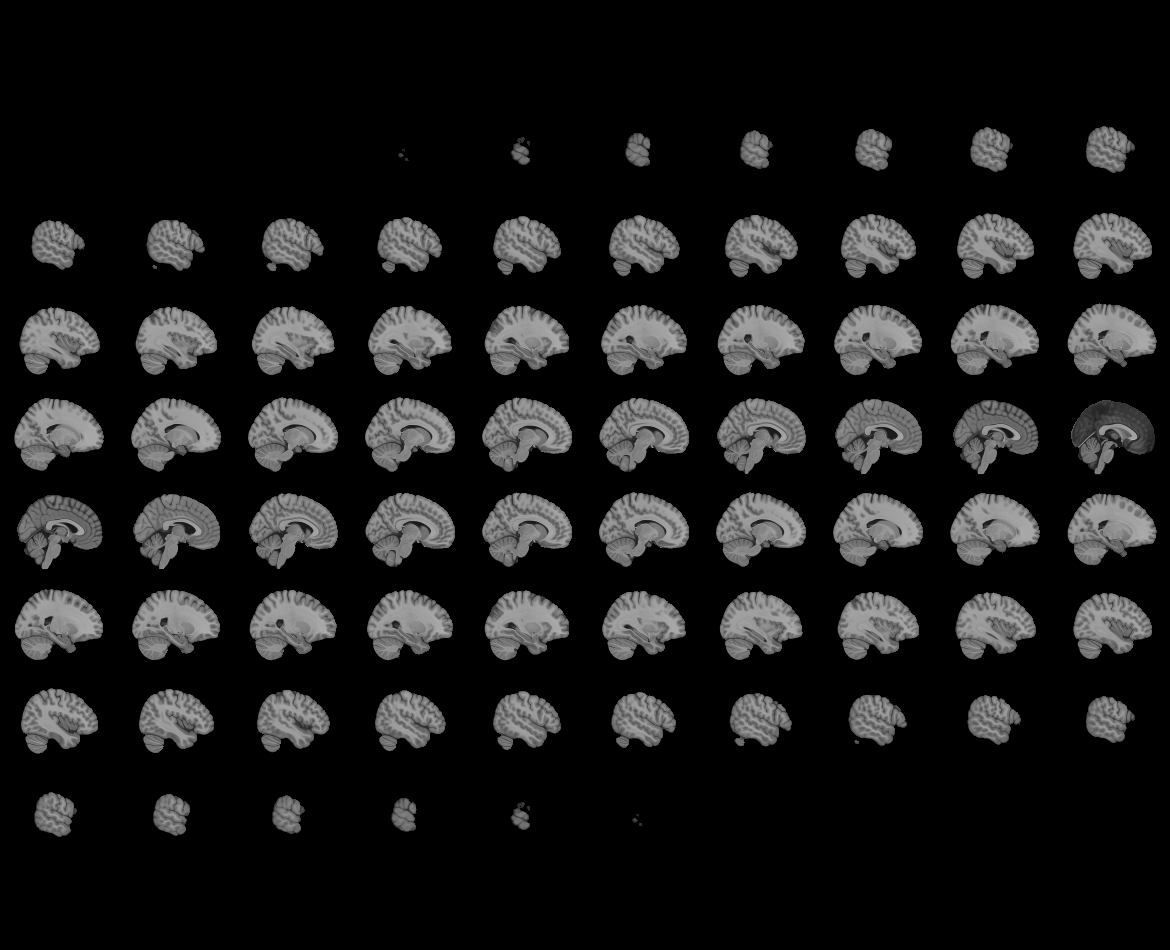
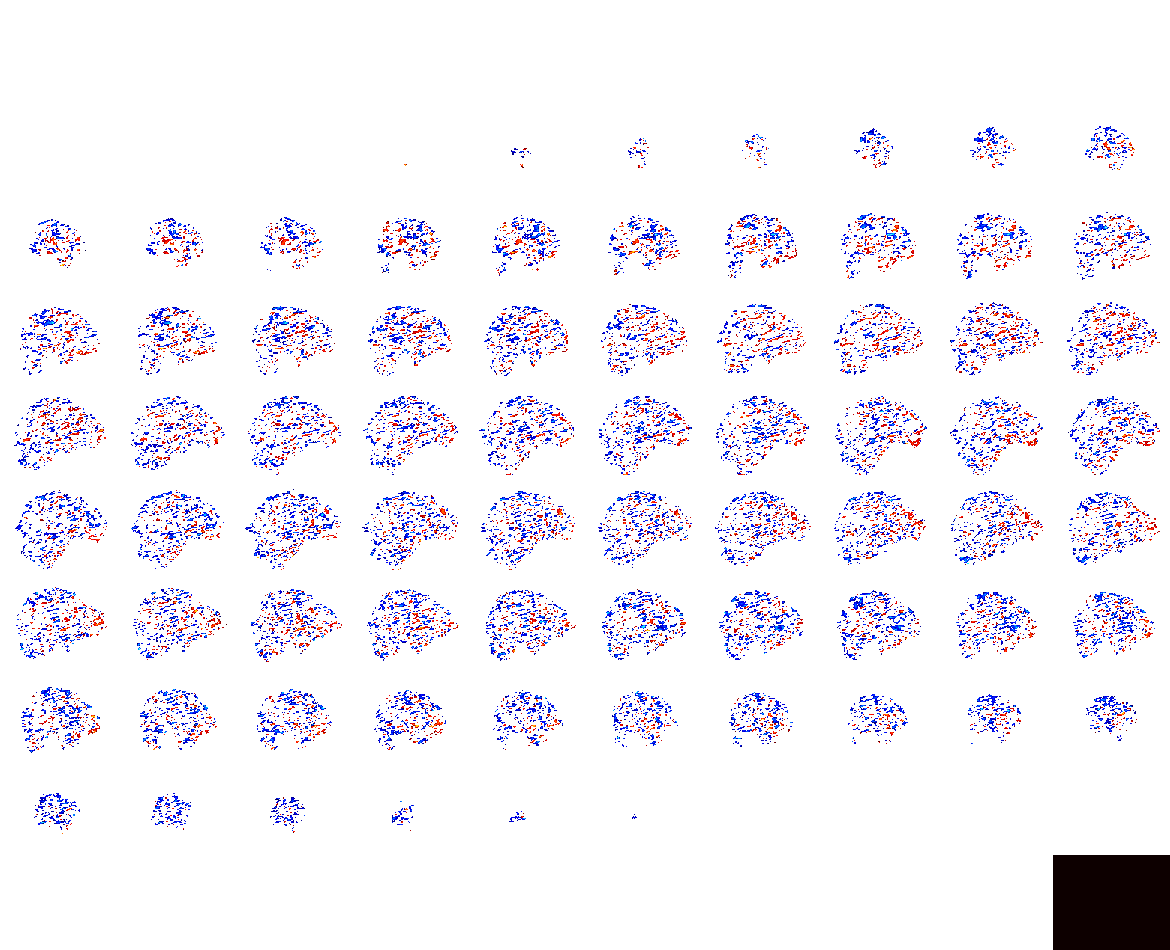

In [17]:
plotting.view_img(test_zmap_fpath, threshold=1.5, 
                  cut_coords=[-50,-32, 14],
                 )

In [18]:
test_zmap_fpath = ('/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/task-stgrid_run-all/'+
                   'sub-FLT02_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim16_zmap.nii.gz')

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



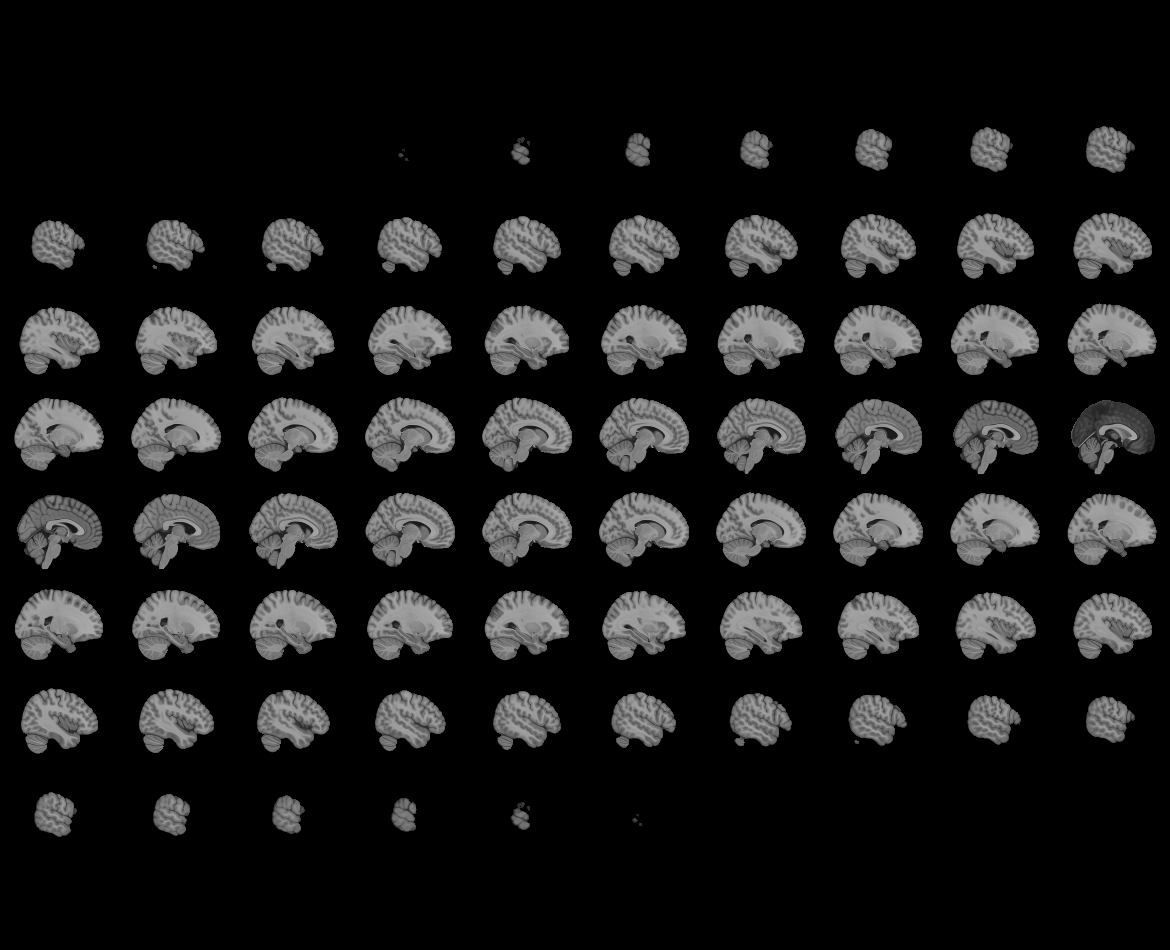
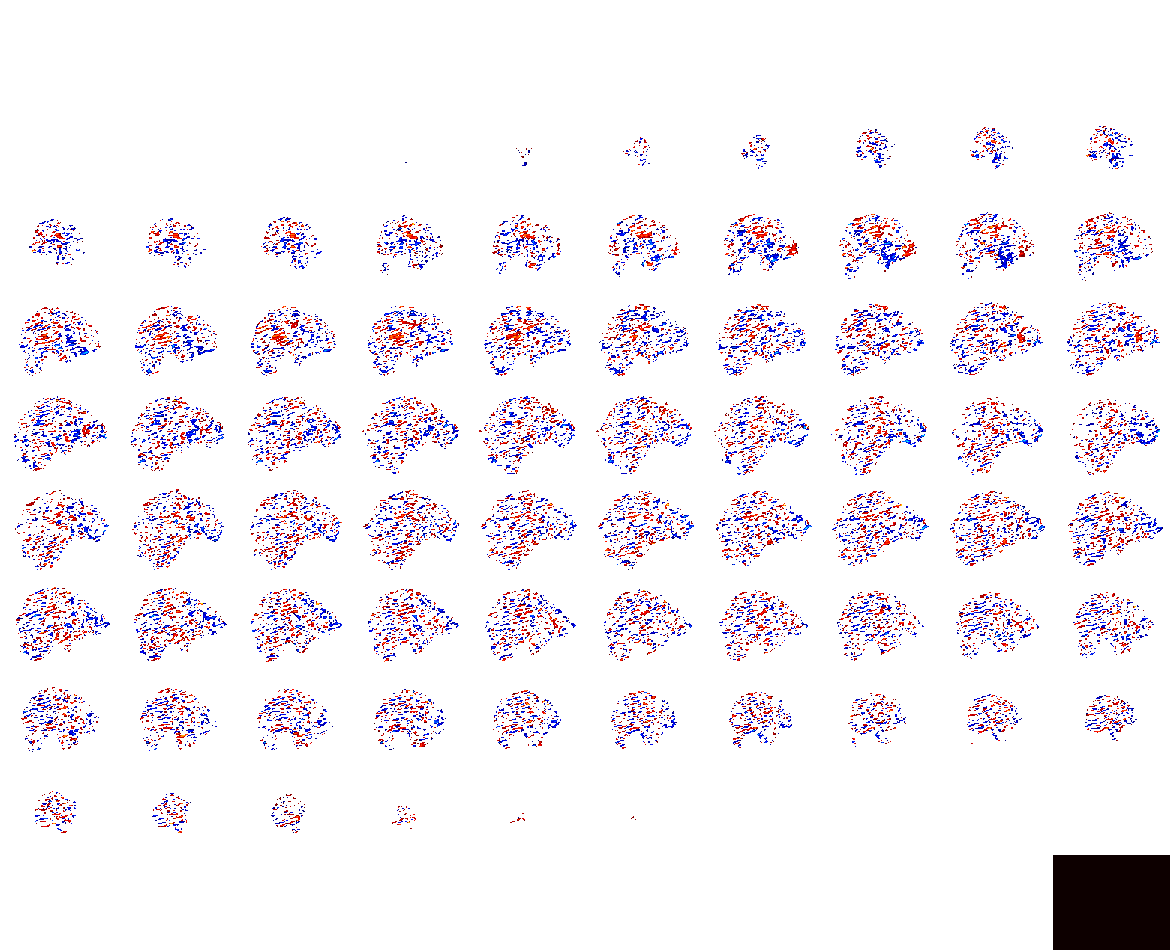

In [19]:
plotting.view_img(test_zmap_fpath, threshold=1.5, 
                  cut_coords=[-50,-32, 14],
                 )